In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
import phidl.geometry as pg
import shapely as sh
from phidl.quickplotter import quickplot2 as qp

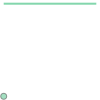

In [15]:
xo,yo=5,3
xi,yi=7,3
xp,yp=5,1
p1=sh.Point(xo,yo)
p2=sh.Point(xi,yi)
p3=sh.Point(xp,yp)
sh.LineString([p1,p2]).union(p3)

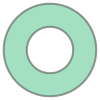

In [30]:
t=np.linspace(0,2*np.pi,100)
rad=5
x,y=rad*np.cos(t),rad*np.sin(t)
xs,ys=rad/2*np.cos(t),rad/2*np.sin(t)
xy_2d = np.vstack((x,y)).T
circle=sh.LineString(xy_2d)
polycircle1=sh.Polygon(circle)
polycircle2=sh.Polygon( np.vstack((xs,ys)).T)

sh_donut=polycircle1.difference(polycircle2)
sh_donut

In [31]:
dev=pg.Device()
c1=pg.circle(radius=rad,layer=1)
c2=pg.circle(radius=rad/2,layer=2)
# dev<<c1
# dev<<c2
c3=pg.boolean(c1,c2,operation='A-B')
dev<<c3
qp(dev)
dev.write_gds('myfile.gds')

'myfile.gds'

In [38]:
plt.plot(*sh_donut.exterior.xy,color='r')
for interior in sh_donut.interiors:
    plt.plot(*interior.xy,color='b')

In [44]:
def shapely_to_phidl(sh_pol):
    d1=pg.Device()
    d1.add_polygon(sh_pol.exterior.xy)
    
    d2=pg.Device()
    for interiors in sh_pol.interiors:
        d2.add_polygon(interiors.xy)
    return pg.boolean(d1,d2,operation='A-B')


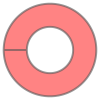

In [50]:
def phidl_to_shapely(dev):
    return sh.unary_union([sh.Polygon(p) for p in dev.get_polygons()])

In [66]:
t=np.linspace(0,2*np.pi,200)
r=.1+np.cos(t)**2+np.exp(-(t-np.pi)**2/.1)
x,y=np.cos(t)*r,np.sin(t)*r
sh_pol=sh.Polygon(np.vstack((x,y)).T)
plt.plot(*sh_pol.exterior.xy)

sh_pol_buffer = sh_pol.buffer(.1)
plt.plot(*sh_pol_buffer.exterior.xy)

sh_pol_buffer_2 = sh_pol_buffer.buffer(-.1)
plt.plot(*sh_pol_buffer_2.exterior.xy)


In [139]:
plt.plot(*sh_pol.exterior.xy)
plt.plot(*polycircle2.exterior.xy)

dists=[sh.Point(el).distance(sh_pol) for el in polycircle2.exterior.coords]

def get_norm(curve):
    xy=np.asarray(curve.coords)
    dxy=np.gradient(xy,axis=0)
    dxy = dxy/np.sqrt(np.sum( dxy**2,axis=1)).reshape(-1,1)
    return dxy[:,::-1]*np.array([-1,1])  #(-dy,dx)
norm=get_norm(polycircle2.exterior)



In [143]:
xy=np.asarray(polycircle2.exterior.coords)
xy_in = xy + .5*np.asarray(dists).reshape(-1,1)*norm


for i in range(len(xy)):
    x = [xy[i,0],xy_in[i,0]]
    y = [xy[i,1],xy_in[i,1]]
    plt.plot(x,y,color='k')
plt.plot(*xy.T)
plt.plot(*xy_in.T)
plt.plot(*sh_pol.exterior.xy)

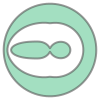

In [145]:
polycircle2.difference( sh.Polygon(xy_in[:-2,:]))

In [151]:
interior_curve_via_buffer=sh.unary_union([sh.Point(el).buffer(.5*d) for el,d in zip(polycircle2.exterior.coords,dists)]).interiors[0]

In [155]:
plt.plot(*polycircle2.difference( sh.Polygon(xy_in[:-2,:])).interiors[0].xy)
plt.plot(*polycircle2.difference(sh.Polygon(interior_curve_via_buffer)).interiors[0].xy)

In [170]:
interpolated_points=polycircle2.exterior.interpolate( np.linspace(0,1,1000), normalized=True)
norm=get_norm(sh.LineString(interpolated_points))
dists=[p.distance(sh_pol) for p in interpolated_points]

buffered_points = [p.buffer(.5*d) for p,d in zip(interpolated_points,dists)]
plt.plot(*sh.unary_union(buffered_points).interiors[0].xy,color='r')

In [171]:
### starting a device

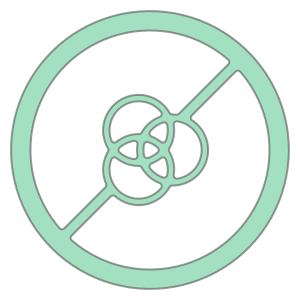

In [207]:
t = np.linspace(0,2*np.pi,100)
rad=50
sh_dev=[]
for ang in np.arange(0,2*np.pi,2/3*np.pi):
    cx,cy=np.cos(ang)*35,np.sin(ang)*35
    x,y=np.cos(t)*rad+cx,np.sin(t)*rad+cy
    sh_dev.append(sh.LineString( np.vstack((x,y)).T))
outer_circ = sh.LineString( np.vstack((200*np.cos(t),200*np.sin(t))).T).buffer(15)
three_rings=sh.unary_union(sh_dev).buffer(5)
cross_bar= (sh.LineString([sh.Point(-300,-300),sh.Point(300,300)])).buffer(8)
cutout=sh.Polygon(outer_circ.interiors[0]).difference(sh.Polygon(three_rings.exterior))
cross_bar=cross_bar.intersection(cutout)

dev = outer_circ.union(three_rings).union(cross_bar).buffer(5).buffer(-5)
dev

In [206]:
plt.plot(*dev.exterior.xy)
for interior in dev.interiors:
    plt.plot(*interior.xy)